I have used the reference from kaggle.Time Series Analysis and Forecasting - Reliance

In [3]:
import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [4]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

# Functions

In [5]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [6]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [7]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 


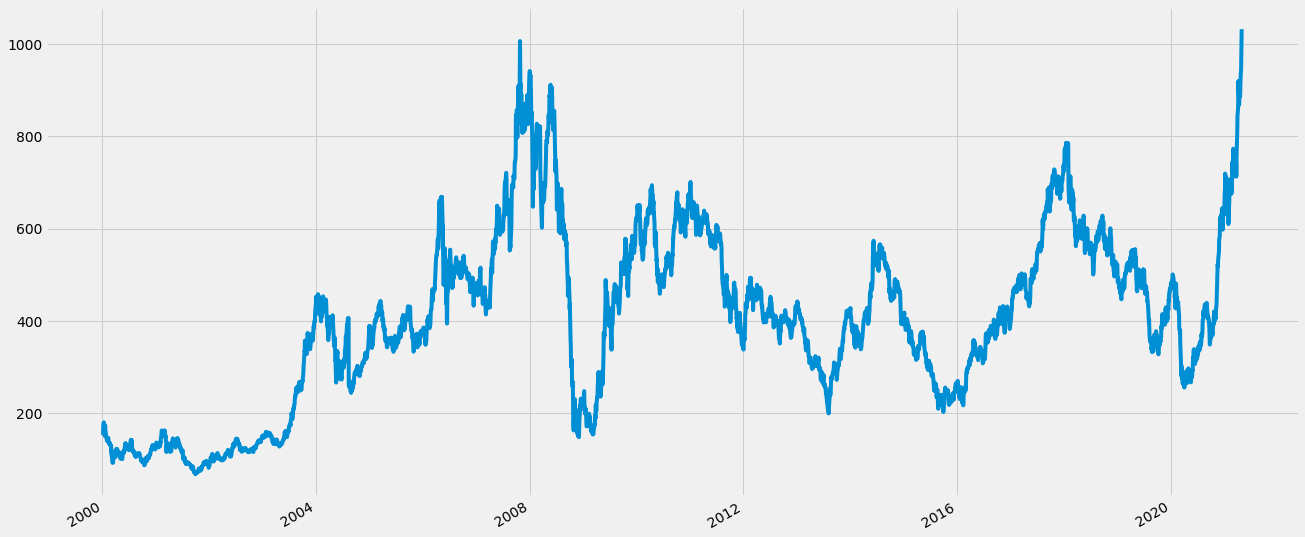

In [9]:
# load the dataset
stock_name = 'TATASTEEL'

df = pd.read_csv(stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [10]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [11]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)


(5255, 50) (5255, 1)


Our `prepare_split` function takes care of reshaping the data into `[batch size, time steps, dimensionality]`

In [12]:

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


In [13]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()


In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 4s 9ms/step - loss: 0.0317 - val_loss: 0.0109
Epoch 2/6
313/313 [==============================] - 3s 9ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 3/6
313/313 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 4/6
313/313 [==============================] - 3s 9ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 5/6
313/313 [==============================] - 3s 9ms/step - loss: 6.6369e-04 - val_loss: 0.0020
Epoch 6/6
313/313 [==============================] - 3s 8ms/step - loss: 5.0505e-04 - val_loss: 0.0011


In [16]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)


8/8 [==============================] - 0s 4ms/step


In [17]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

RMSE: 32.0065


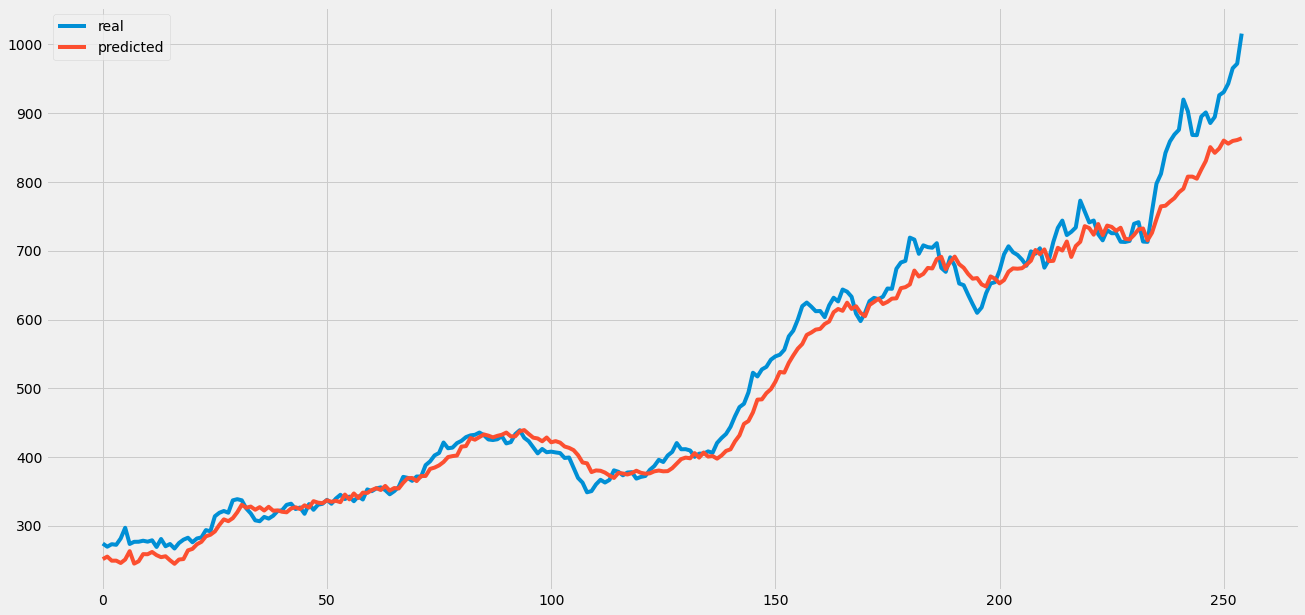

In [18]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [19]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [20]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

Epoch 1/6
313/313 [==============================] - 8s 19ms/step - loss: 8.9103e-04 - val_loss: 5.3592e-04
Epoch 2/6
313/313 [==============================] - 6s 18ms/step - loss: 2.6735e-04 - val_loss: 3.3276e-04
Epoch 3/6
313/313 [==============================] - 6s 18ms/step - loss: 2.0724e-04 - val_loss: 3.0551e-04
Epoch 4/6
313/313 [==============================] - 7s 21ms/step - loss: 1.9984e-04 - val_loss: 3.9370e-04
Epoch 5/6
313/313 [==============================] - 12s 39ms/step - loss: 1.6490e-04 - val_loss: 2.1683e-04
Epoch 6/6
313/313 [==============================] - 6s 20ms/step - loss: 1.5142e-04 - val_loss: 3.3481e-04
Epoch 6: early stopping
8/8 [==============================] - 0s 5ms/step
RMSE: 22.3162


In [21]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

print(xdat.shape, ydat.shape)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(5246, 50) (5246, 10)
(5000, 50, 1) (246, 50, 1) (5000, 10) (246, 10)


In [22]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


In [23]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

Epoch 1/6
313/313 [==============================] - 8s 20ms/step - loss: 0.0406 - val_loss: 0.0115
Epoch 2/6
313/313 [==============================] - 6s 18ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 3/6
313/313 [==============================] - 6s 18ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 4/6
313/313 [==============================] - 6s 18ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/6
313/313 [==============================] - 6s 18ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 6/6
8/8 [==============================] - 0s 7ms/step


In [24]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))))

RMSE: 44.3019


## Import Libraries

In [25]:
# pip install pmdarima

In [26]:
# !pip install yfinance

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
# from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

In [30]:
# kaggle kernels output umang5916/time-series-analysis-and-forecasting-reliance -p /path/to/dest

## Import dataset

In [31]:
# company_list=["ADANIPORTS.csv","ASIANPAINT.csv","AXISBANK.csv","BAJAJ-AUTO.csv","BAJAJFINSV.csv","BAJFINANCE.csv","BHARTIARTL.csv","BPCL.csv","BRITANNIA.csv","CIPLA.csv","COALINDIA.csv","DRREDDY.csv","EICHERMOT.csv","GAIL.csv","GRASIM.csv","HCLTECH.csv","HDFC.csv","HDFCBANK.csv","HEROMOTOCO.csv","HINDALCO.csv","HINDUNILVR.csv","ICICIBANK.csv","INDUSINDBK.csv","INFRATEL.csv","INFY.csv","IOC.csv","ITC.csv","JSWSTEEL.csv","KOTAKBANK.csv","LT.csv","MARUTI.csv","MM.csv","NESTLEIND.csv","NTPC.csv","ONGC.csv","POWERGRID.csv","RELIANCE.csv","SBIN.csv","SHREECEM.csv","SUNPHARMA.csv","TATAMOTORS.csv","TATASTEEL.csv","TCS.csv","TECHM.csv","TITAN.csv","ULTRACEMCO.csv","UPL.csv","VEDL.csv","WIPRO.csv","ZEEL.csv"]
# len(company_list)

In [32]:
# !pip install yfinance

In [33]:
# import yfinance as yf

In [34]:
# df_dict = {}
# for x in company_list[:1]:
#   df_dict[x] = yf.download(x)

In [36]:
start_date = '2021-07-23'
end_date = '2022-07-29'

# # Get the data
# data = yf.download('ZOMATO.NS', start_date, end_date)

In [37]:
df=pd.read_csv('RELIANCE.csv')

## Converting Date into DateTime format 

In [38]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [39]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


## data summary

In [40]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2.456000e+03,4.792000e+03,4792.000000
mean,1010.984866,1012.602375,1026.823803,996.886977,1011.157143,1011.316839,1011.937409,5.583028e+06,6.076715e+14,1.452306e+05,2.280885e+06,0.435039
std,570.987079,572.575893,581.986757,560.703328,570.938608,571.046753,571.222520,4.983793e+06,8.369739e+14,1.297557e+05,1.882665e+06,0.144722
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,572.137500,572.925000,582.950000,564.237500,572.062500,572.512500,573.190000,2.836454e+06,2.203354e+14,7.215900e+04,1.194524e+06,0.323325
50%,937.950000,939.000000,950.075000,927.550000,939.025000,938.275000,939.785000,4.213432e+06,3.662999e+14,1.021435e+05,1.810434e+06,0.449450
75%,1247.387500,1247.675000,1267.350000,1227.450000,1248.287500,1248.275000,1247.375000,6.602604e+06,6.656490e+14,1.686702e+05,2.752935e+06,0.544300
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.428490e+06,3.495888e+07,0.978300


In [41]:
df.shape

(5306, 14)

## Check for missing values

In [42]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [43]:
missing_table=missing_values_table(df)
missing_table

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Trades,2850,53.7
Deliverable Volume,514,9.7
%Deliverble,514,9.7


* There are missing vales in Trades , Deliverable Volumne and % deliverable

## Visualizing the locations of the missing data

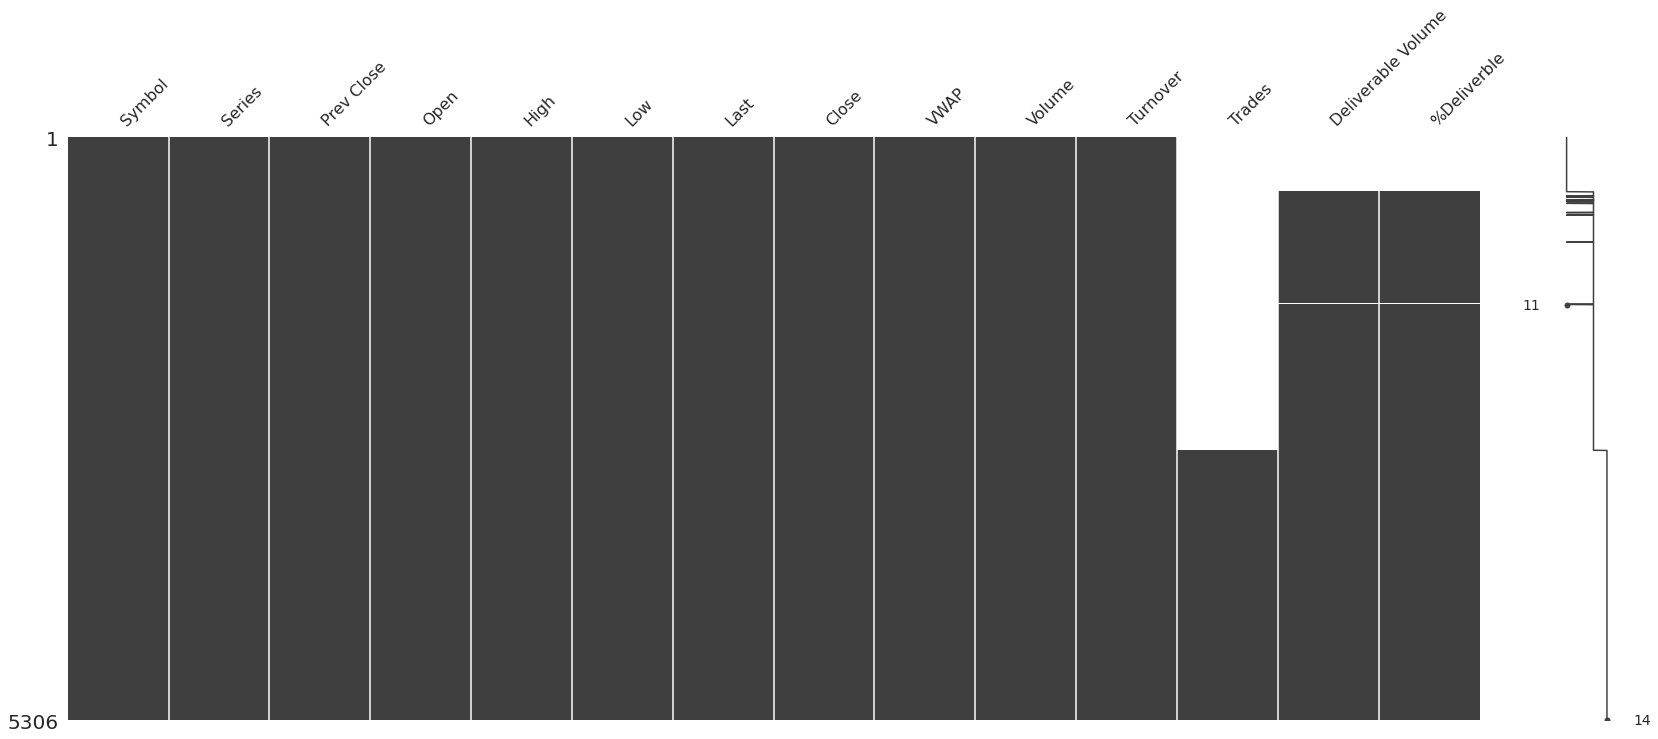

In [44]:
msno.matrix(df)

* As you can see all the starting values are missing in columns Trades , Deliverable Volume	 and %Deliverble

## Handling missing values 

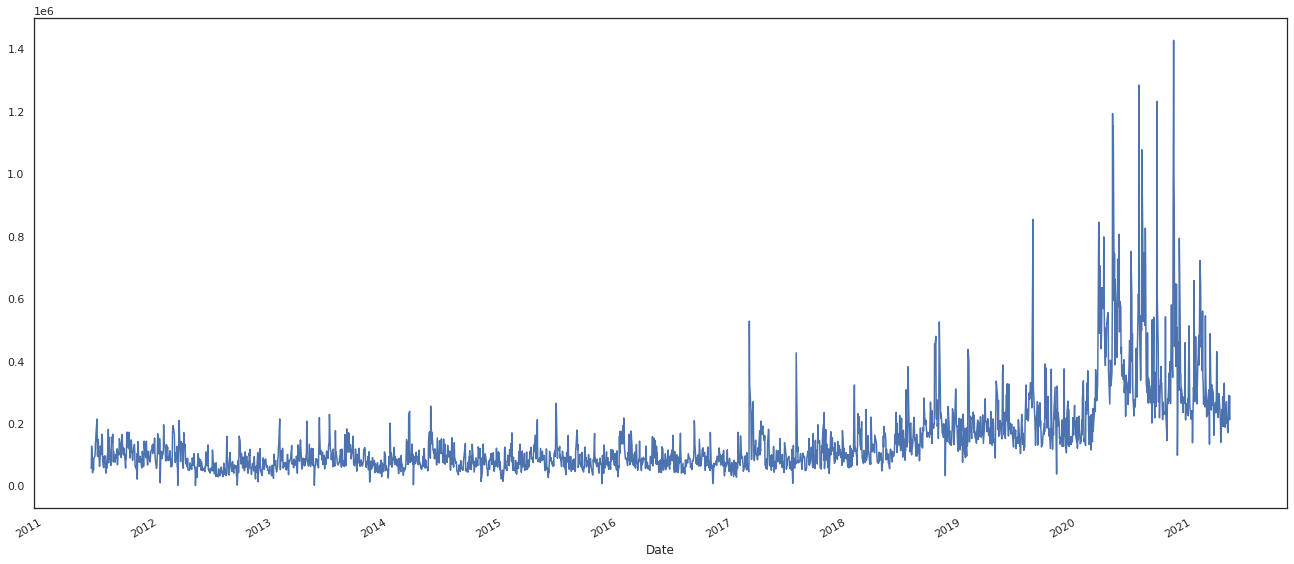

In [45]:
df.Trades.plot()

In [46]:
df.Trades[:2850]

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2011-05-25   NaN
2011-05-26   NaN
2011-05-27   NaN
2011-05-30   NaN
2011-05-31   NaN
Name: Trades, Length: 2850, dtype: float64

* we don't have data of Trades on and before 31-05-2011 

In [47]:
# removing missing columns

df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)


<b>Exploratory Data Analysis</b>

## Plotting VWAP(Volume Weighted Average Price) over time

In [48]:
fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP over time',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

 ## Visualising using KDEs
 Summarizing the data with Density plots to see where the mass of the data is located

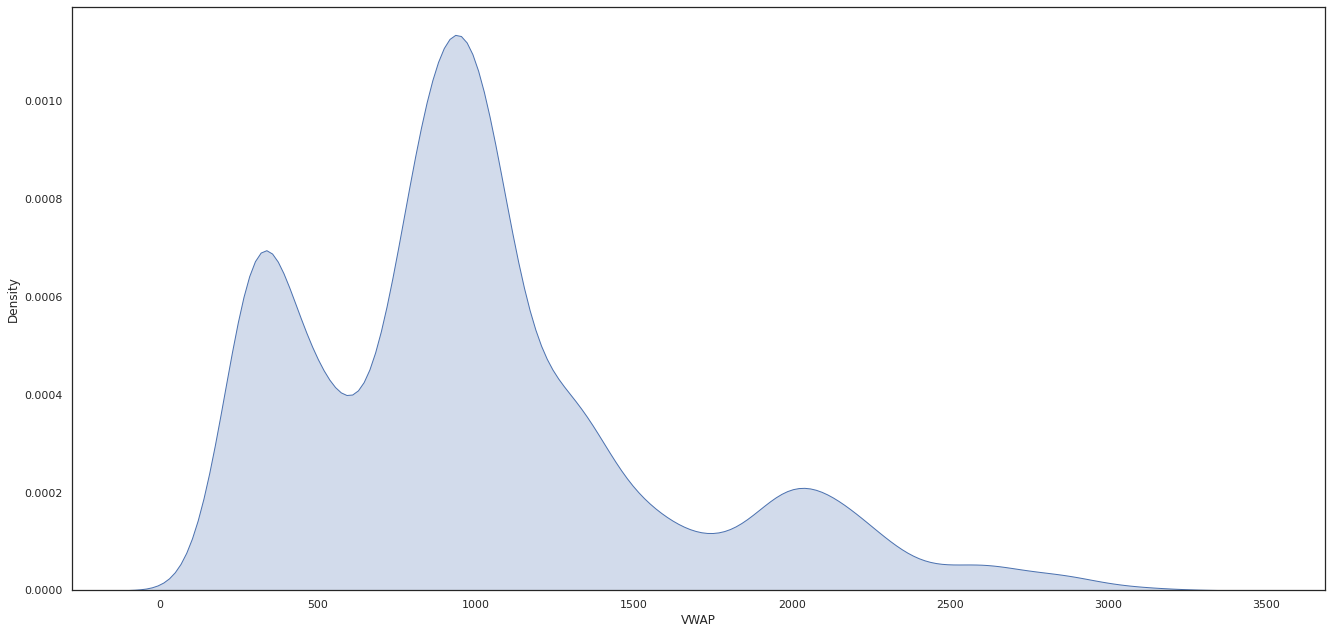

In [49]:
sns.kdeplot(df['VWAP'],shade=True)


## VWAP in 2019

In [50]:
fig = go.Figure([go.Scatter(x=df.loc['2019', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2019',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")

fig.show()

* There was many dips in year 2019 like in May-June , Aug-Sept and in end of the Sept month 

## VWAP in 2020

In [51]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2020',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* as you can see there is deep in the month of march and april.
* Steady increase after month of april .

## Open,close,High,low prices over time 

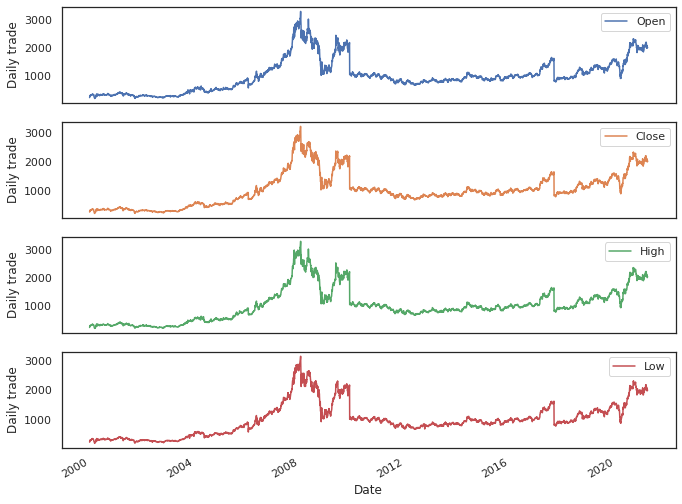

In [ ]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

* All are following same pattern 

### Q-Q plot of VWAP 

used to determine whether dataset is distributed a certain way 

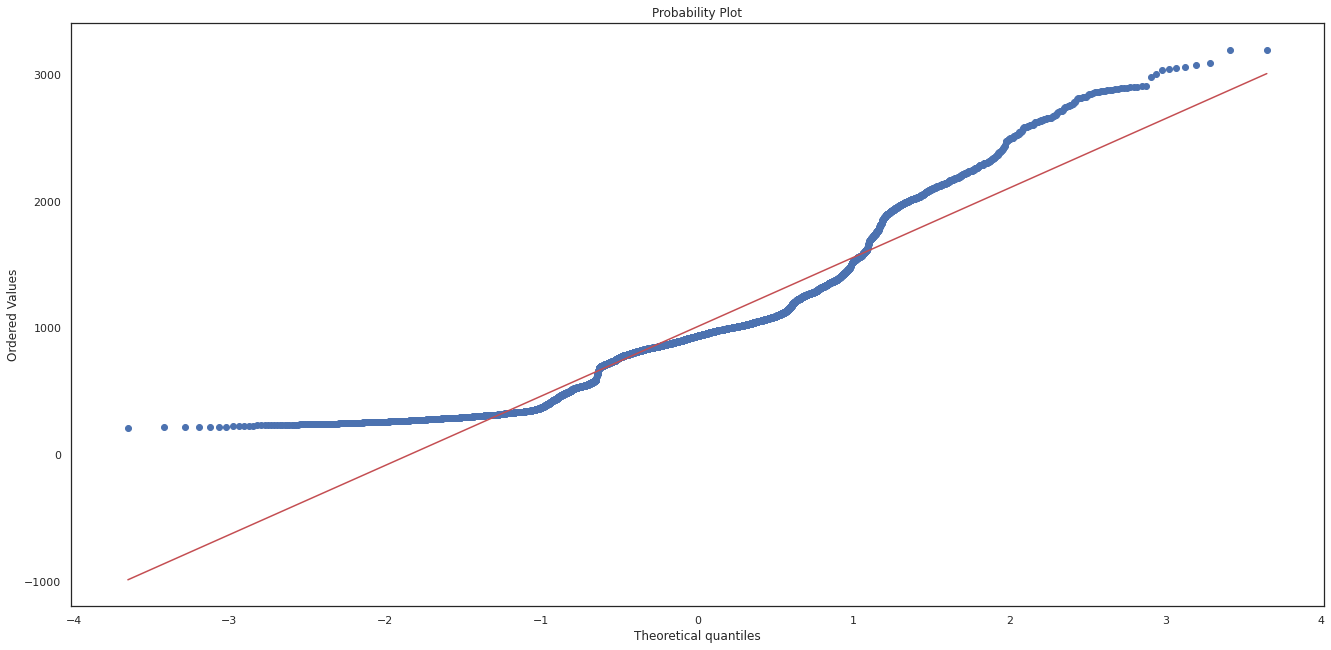

In [52]:
scipy.stats.probplot(df.VWAP,plot=pylab)
pylab.show()

* data is not normally distributed , however this is what we usually expect from timeseries 

In [53]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [54]:
dicky_fuller_test(df['VWAP'])

ADF Statistic: -1.837362
p-value: 0.362077
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


## Seasonal Decompose

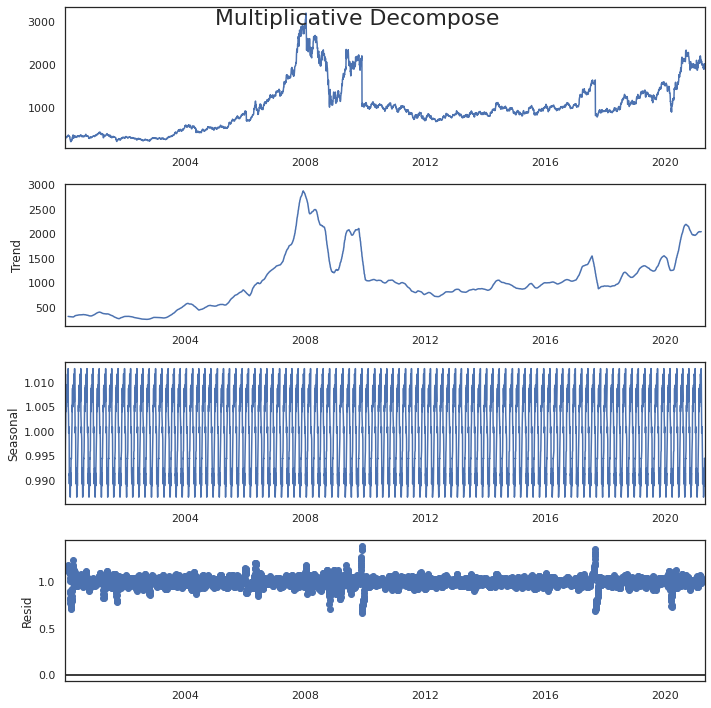

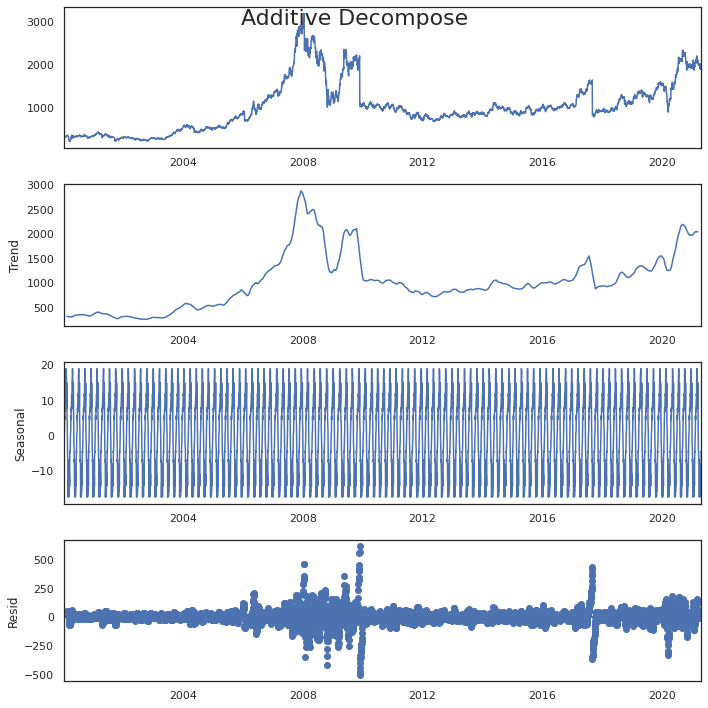

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})
y = df['VWAP'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* cyclic patter is shown in every 30 days (monthly)

### Differencing

In [56]:
df['vwap_diff']=df['VWAP']-df['VWAP'].shift(1)

In [57]:
fig = go.Figure([go.Scatter(x=df.index,y=df.VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='VWAP over time ')
fig.show()

In [58]:
fig = go.Figure([go.Scatter(x=df.index,y=df.vwap_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference VWAP over time ')
fig.show()

## Plotting ACF and PACF 

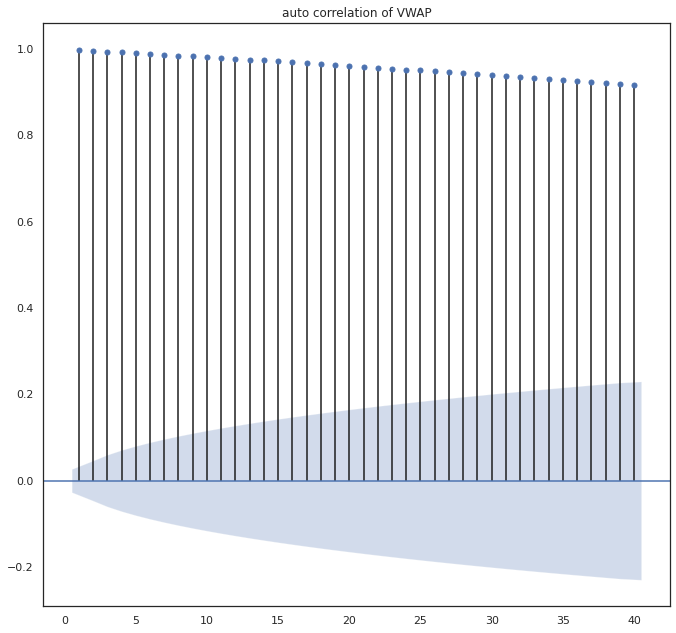

In [59]:
sm.graphics.tsa.plot_acf(df['VWAP'].iloc[1:], lags=40,title='auto correlation of VWAP',zero=False)
plt.show()

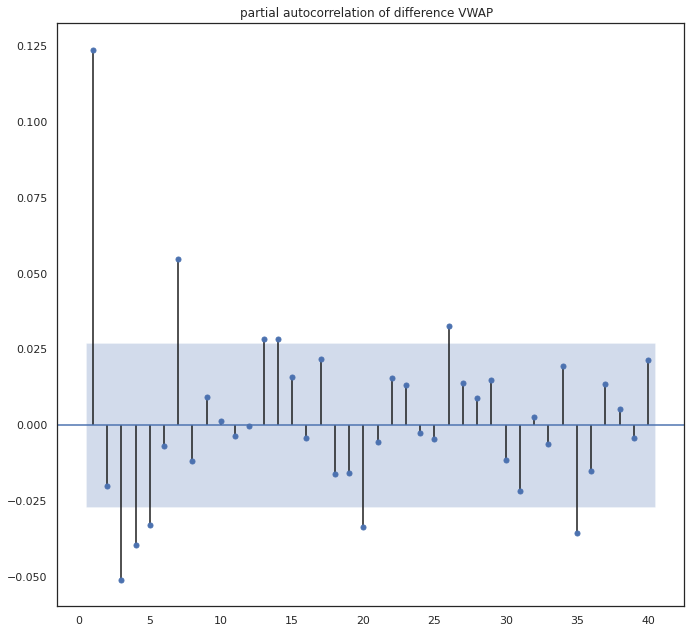

In [61]:
sm.graphics.tsa.plot_pacf(df['vwap_diff'].iloc[1:], lags=40,title='partial autocorrelation of difference VWAP  ',zero=False)
plt.show()

<b> Feature Engineering </b>

In [62]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,vwap_diff
Date,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,14.15
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,11.27
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,20.66
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,13.46


In [63]:
df=df.reset_index()

In [64]:
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)

In [65]:

df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek


In [66]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,...,1010.799805,1010.160950,1006.543823,14.784650,22.771172,47.599754,1,1,3,0
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,...,251.699997,251.699997,251.699997,14.784650,22.771172,47.599754,1,1,4,1
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,...,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,1,1,5,2
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,...,268.683319,268.683319,268.683319,15.642277,15.642277,15.642277,1,1,6,3
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,...,282.899994,275.100006,275.100006,11.255332,18.105661,18.105661,1,1,7,4


In [67]:

df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]


In [68]:
df_valid['Date'].describe()

count                     577
unique                    577
top       2019-01-01 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2021-04-30 00:00:00
Name: Date, dtype: object

In [69]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



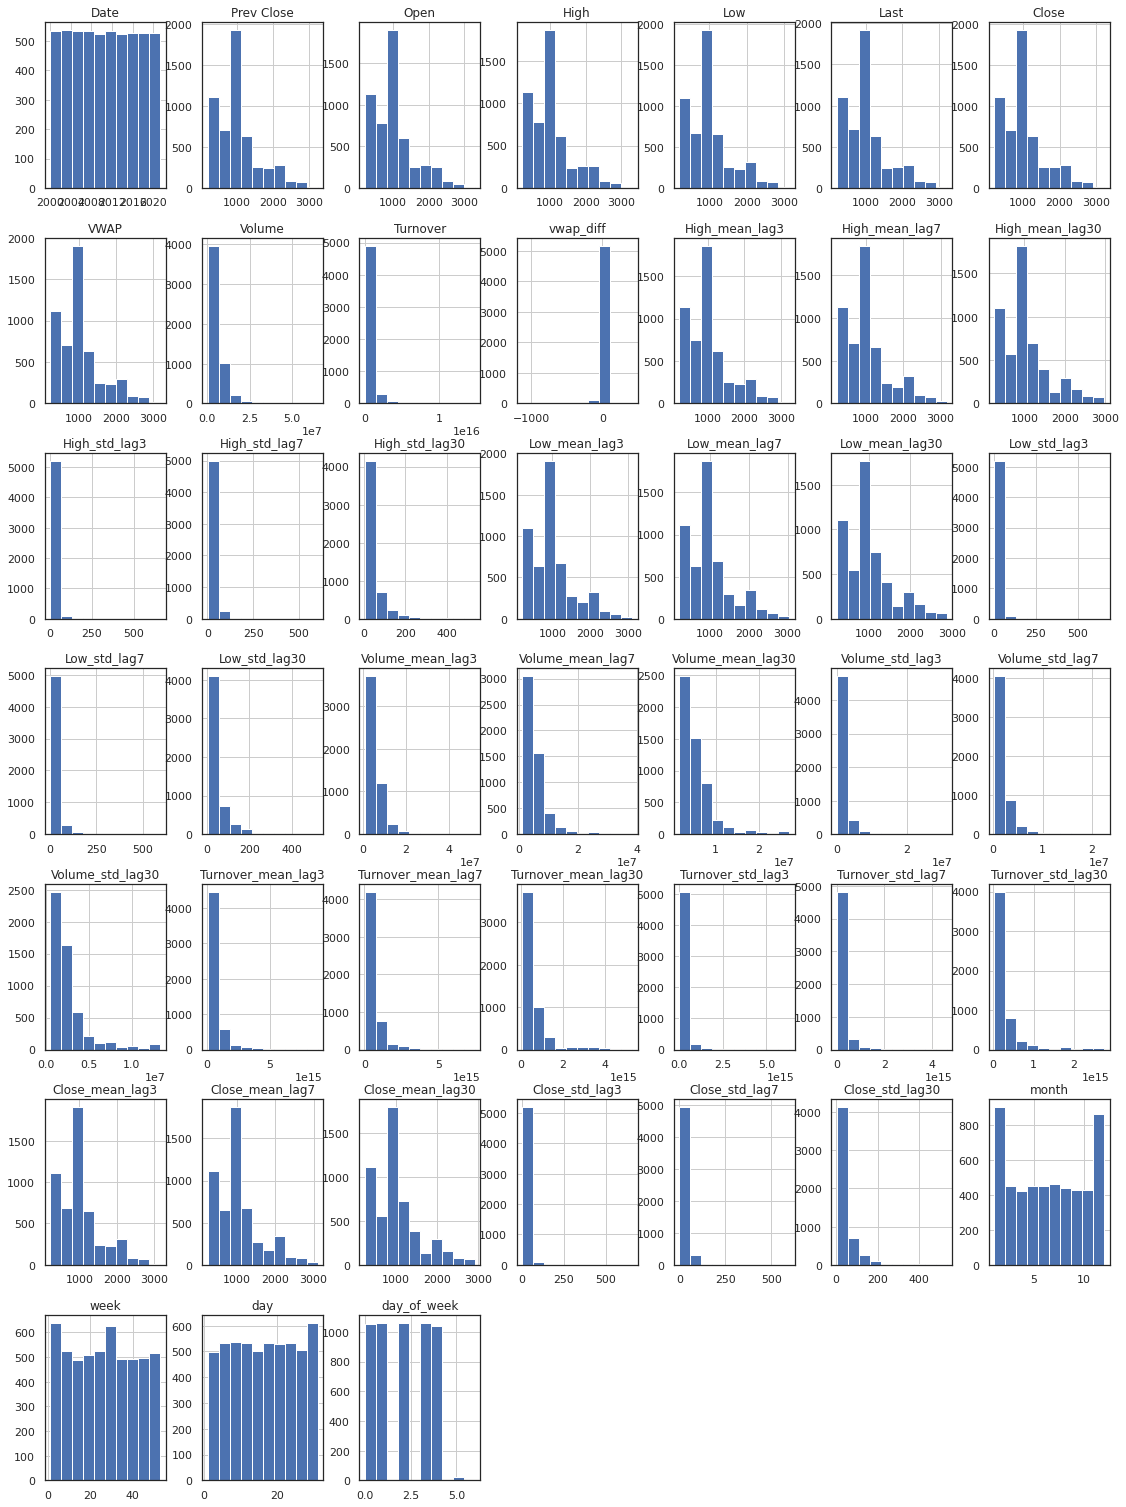

In [70]:
fig = plt.figure(figsize = (17,25))
ax = fig.gca()
hist=df.hist(ax = ax)

In [71]:
dataset = df[exogenous_features].values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [72]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [73]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [74]:
model = Sequential()
model.add(LSTM(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)

In [75]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 100)                  53600     
                                                                 
 dense_3 (Dense)             (1, 1)                    101       
                                                                 
Total params: 53,701
Trainable params: 53,701
Non-trainable params: 0
_________________________________________________________________


In [76]:
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

1062/1062 [==============================] - 2s 2ms/step
rmse:0.04201327254757421 MAE:0.02923509106040001


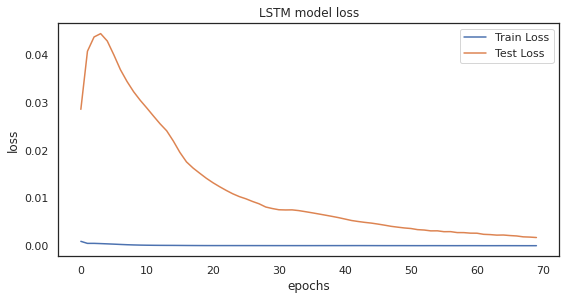

In [77]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

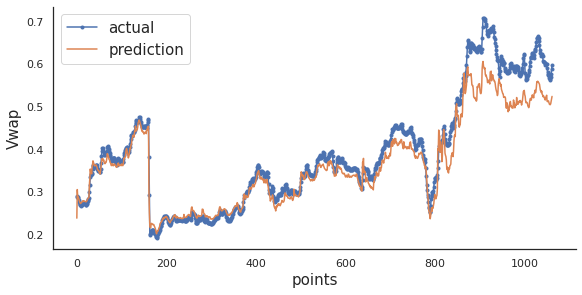

In [78]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

LSTM gives an excellent score on our dataset. Let's checkout a simple RNN model!

In [79]:
model = Sequential()
model.add(SimpleRNN(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (1, 100)                  13400     
                                                                 
 dense_4 (Dense)             (1, 1)                    101       
                                                                 
Total params: 13,501
Trainable params: 13,501
Non-trainable params: 0
_________________________________________________________________


In [80]:
yhat2 = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat2)
print('rmse:{} MAE:{}'.format(rmse,mae))

1062/1062 [==============================] - 2s 2ms/step
rmse:0.04201327254757421 MAE:0.12424270808696747


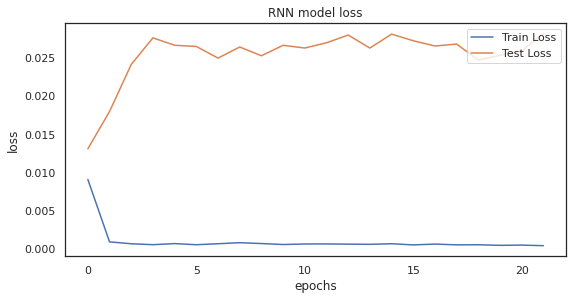

In [81]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

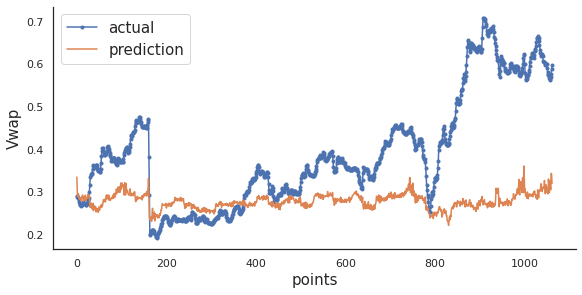

In [82]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat2, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

In [86]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 9.9 MB 37.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [87]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

In [89]:
# kaggle kernels output umang5916/time-series-analysis-and-forecasting-reliance -p /path/to/dest

## Import dataset

In [90]:
# company_list=["ADANIPORTS.csv","ASIANPAINT.csv","AXISBANK.csv","BAJAJ-AUTO.csv","BAJAJFINSV.csv","BAJFINANCE.csv","BHARTIARTL.csv","BPCL.csv","BRITANNIA.csv","CIPLA.csv","COALINDIA.csv","DRREDDY.csv","EICHERMOT.csv","GAIL.csv","GRASIM.csv","HCLTECH.csv","HDFC.csv","HDFCBANK.csv","HEROMOTOCO.csv","HINDALCO.csv","HINDUNILVR.csv","ICICIBANK.csv","INDUSINDBK.csv","INFRATEL.csv","INFY.csv","IOC.csv","ITC.csv","JSWSTEEL.csv","KOTAKBANK.csv","LT.csv","MARUTI.csv","MM.csv","NESTLEIND.csv","NTPC.csv","ONGC.csv","POWERGRID.csv","RELIANCE.csv","SBIN.csv","SHREECEM.csv","SUNPHARMA.csv","TATAMOTORS.csv","TATASTEEL.csv","TCS.csv","TECHM.csv","TITAN.csv","ULTRACEMCO.csv","UPL.csv","VEDL.csv","WIPRO.csv","ZEEL.csv"]
# len(company_list)

In [91]:
# !pip install yfinance

In [92]:
# import yfinance as yf

In [93]:
# df_dict = {}
# for x in company_list[:1]:
#   df_dict[x] = yf.download(x)

In [94]:
# start_date = '2021-07-23'
# end_date = '2022-07-29'

# # Get the data
# data = yf.download('ZOMATO.NS', start_date, end_date)

In [95]:
df=pd.read_csv('RELIANCE.csv')

## Converting Date into DateTime format 

In [96]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [97]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


## data summary

In [98]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2.456000e+03,4.792000e+03,4792.000000
mean,1010.984866,1012.602375,1026.823803,996.886977,1011.157143,1011.316839,1011.937409,5.583028e+06,6.076715e+14,1.452306e+05,2.280885e+06,0.435039
std,570.987079,572.575893,581.986757,560.703328,570.938608,571.046753,571.222520,4.983793e+06,8.369739e+14,1.297557e+05,1.882665e+06,0.144722
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,572.137500,572.925000,582.950000,564.237500,572.062500,572.512500,573.190000,2.836454e+06,2.203354e+14,7.215900e+04,1.194524e+06,0.323325
50%,937.950000,939.000000,950.075000,927.550000,939.025000,938.275000,939.785000,4.213432e+06,3.662999e+14,1.021435e+05,1.810434e+06,0.449450
75%,1247.387500,1247.675000,1267.350000,1227.450000,1248.287500,1248.275000,1247.375000,6.602604e+06,6.656490e+14,1.686702e+05,2.752935e+06,0.544300
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.428490e+06,3.495888e+07,0.978300


In [99]:
df.shape

(5306, 14)

## Check for missing values

In [100]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [101]:
missing_table=missing_values_table(df)
missing_table

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Trades,2850,53.7
Deliverable Volume,514,9.7
%Deliverble,514,9.7


* There are missing vales in Trades , Deliverable Volumne and % deliverable

## Visualizing the locations of the missing data

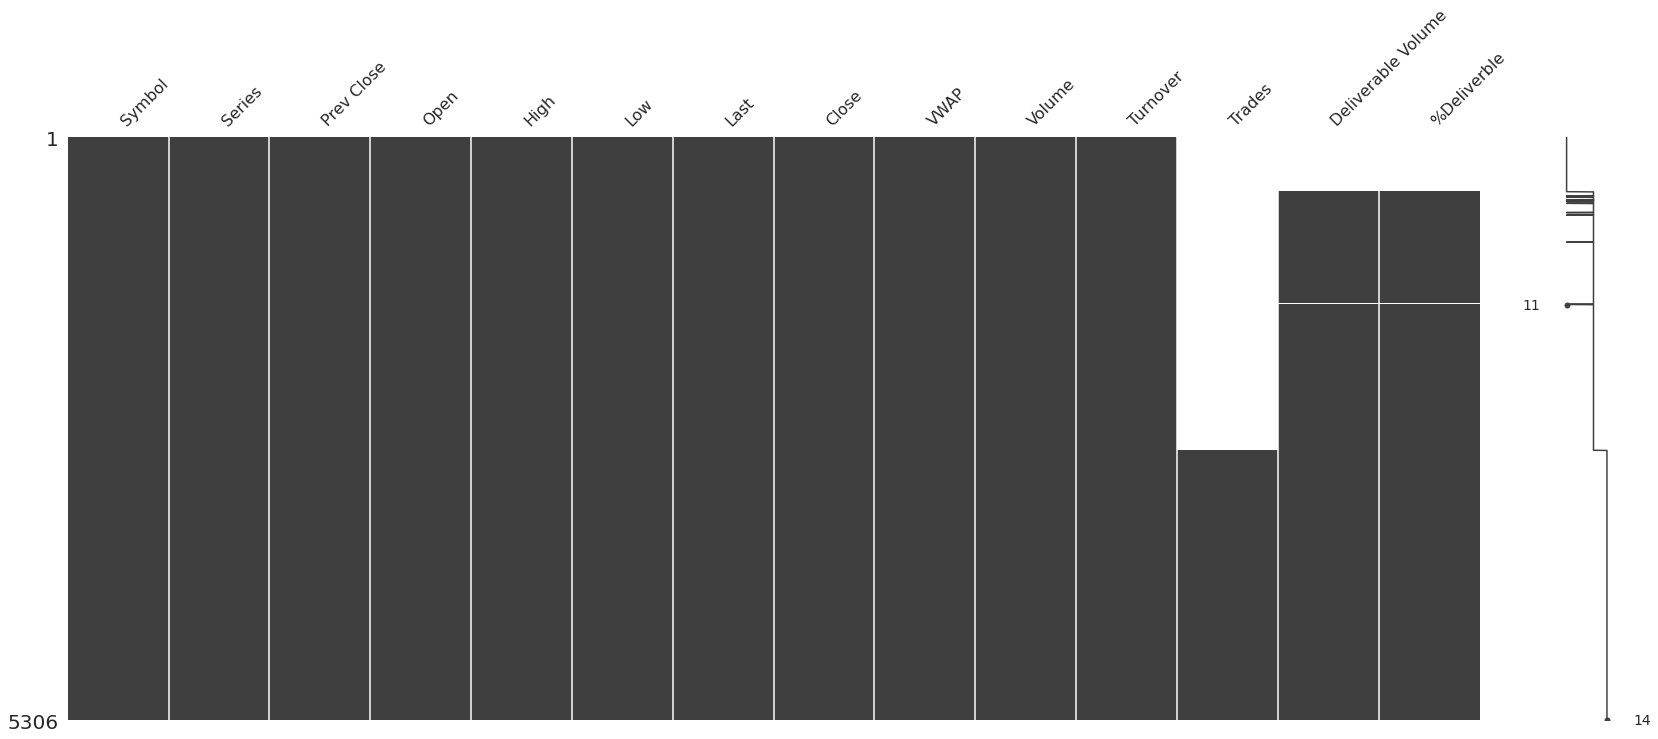

In [102]:
msno.matrix(df)

* As you can see all the starting values are missing in columns Trades , Deliverable Volume	 and %Deliverble

## Handling missing values 

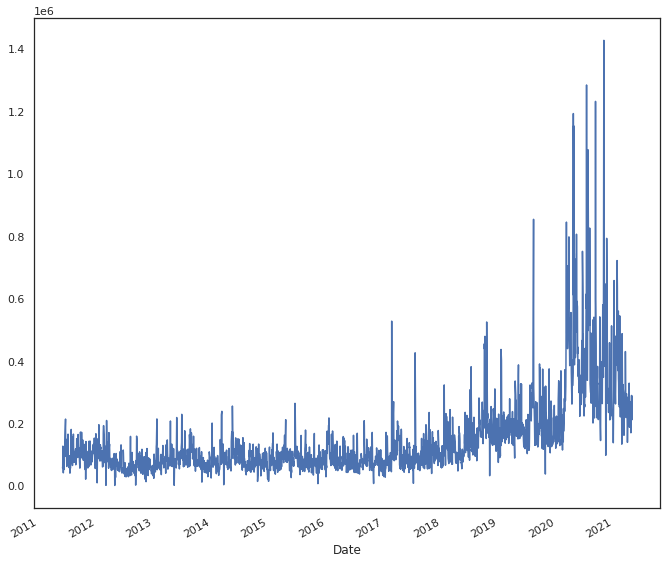

In [103]:
df.Trades.plot()

In [104]:
df.Trades[:2850]

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2011-05-25   NaN
2011-05-26   NaN
2011-05-27   NaN
2011-05-30   NaN
2011-05-31   NaN
Name: Trades, Length: 2850, dtype: float64

* we don't have data of Trades on and before 31-05-2011 

In [105]:
# removing missing columns

df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)


<b>Exploratory Data Analysis</b>

## Plotting VWAP(Volume Weighted Average Price) over time

In [106]:
fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP over time',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

 ## Visualising using KDEs
 Summarizing the data with Density plots to see where the mass of the data is located

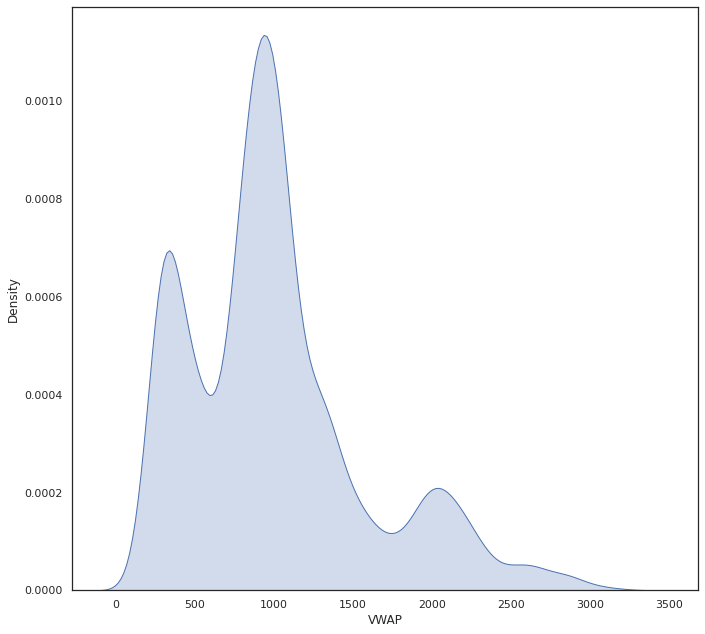

In [107]:
sns.kdeplot(df['VWAP'],shade=True)

## VWAP in 2019

In [108]:
fig = go.Figure([go.Scatter(x=df.loc['2019', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2019',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")

fig.show()

## VWAP in 2020

In [109]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2020',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

## Open,close,High,low prices over time 

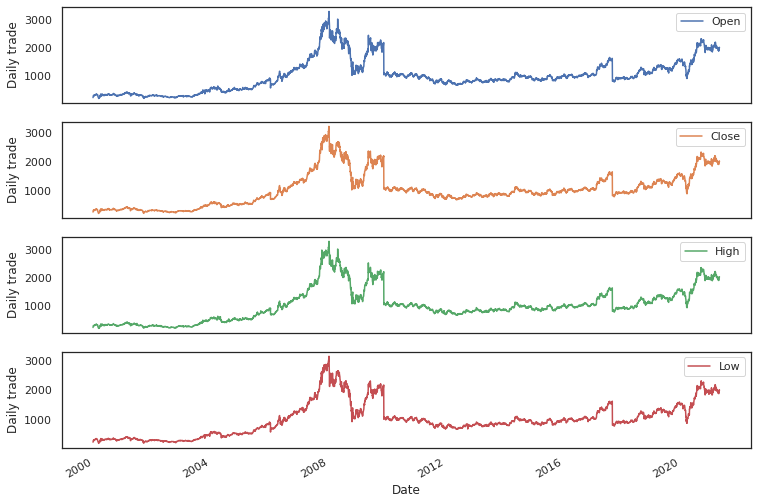

In [110]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

* All are following same pattern 

## Volume over Time 

In [111]:
fig = go.Figure([go.Scatter(x=df.index, y=df['Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume over time'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Volume in 2020

In [112]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'Volume'].index,y=df.loc['2020', 'Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Q-Q plot of VWAP 

used to determine whether dataset is distributed a certain way 

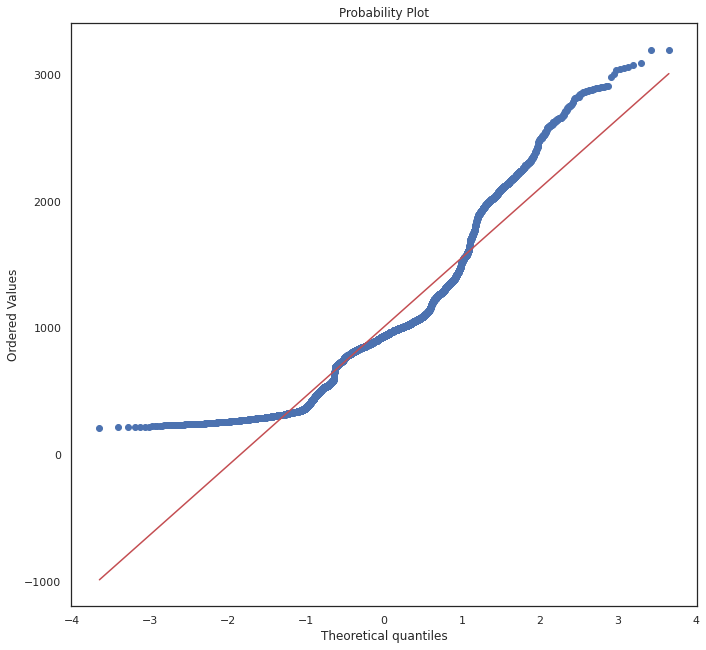

In [113]:
scipy.stats.probplot(df.VWAP,plot=pylab)
pylab.show()

* data is not normally distributed , however this is what we usually expect from timeseries 

## Check Stationarity i.e Dicky Fuller Test

In [114]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [115]:
dicky_fuller_test(df['VWAP'])

ADF Statistic: -1.837362
p-value: 0.362077
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


## Seasonal Decompose

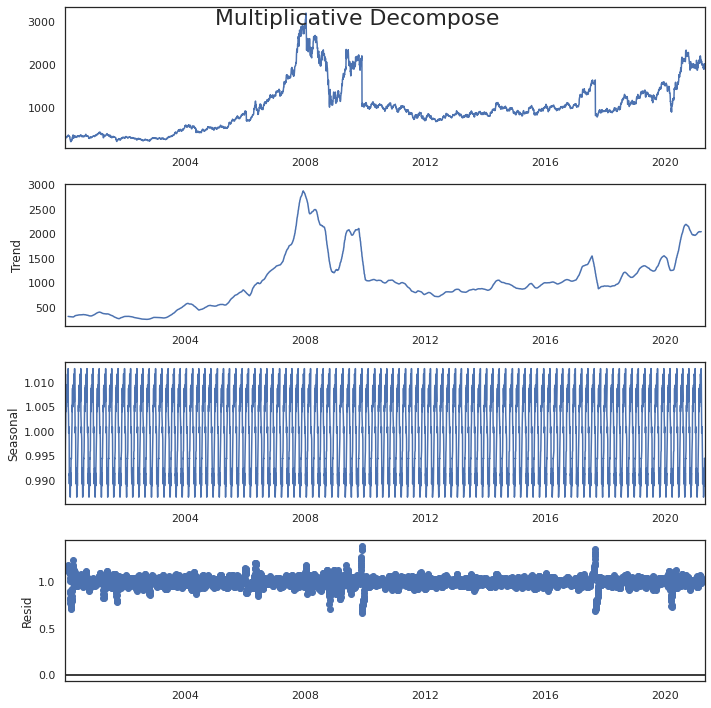

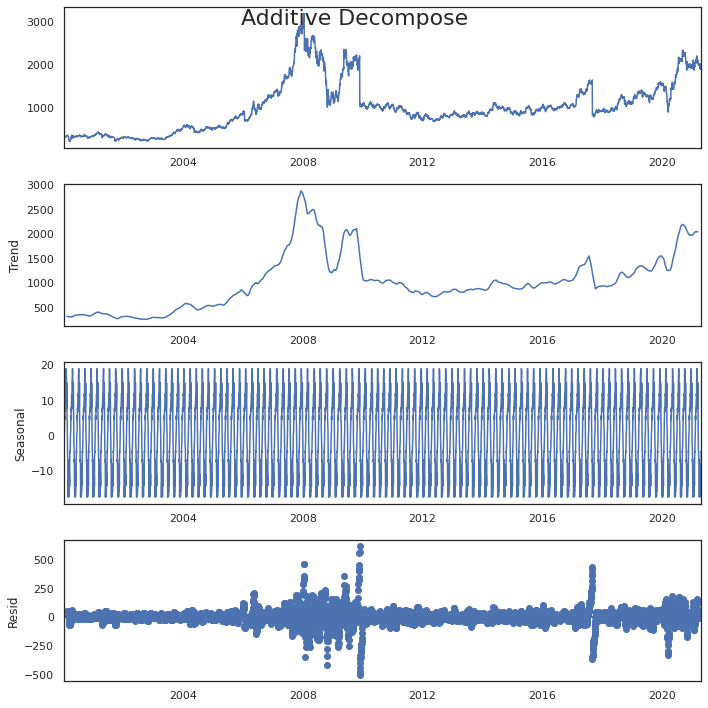

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})
y = df['VWAP'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* cyclic patter is shown in every 30 days (monthly)

## Convert Stationary into Non Stationary

### Differencing

In [117]:
df['vwap_diff']=df['VWAP']-df['VWAP'].shift(1)

In [118]:
fig = go.Figure([go.Scatter(x=df.index,y=df.VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='VWAP over time ')
fig.show()

In [119]:
fig = go.Figure([go.Scatter(x=df.index,y=df.vwap_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference VWAP over time ')
fig.show()

* We don't actually need to convert the time series data into stationary data. For study purpose,I have explained how to check stationarity and how to convert non-stationary data into stationary data 

## Plotting ACF and PACF 

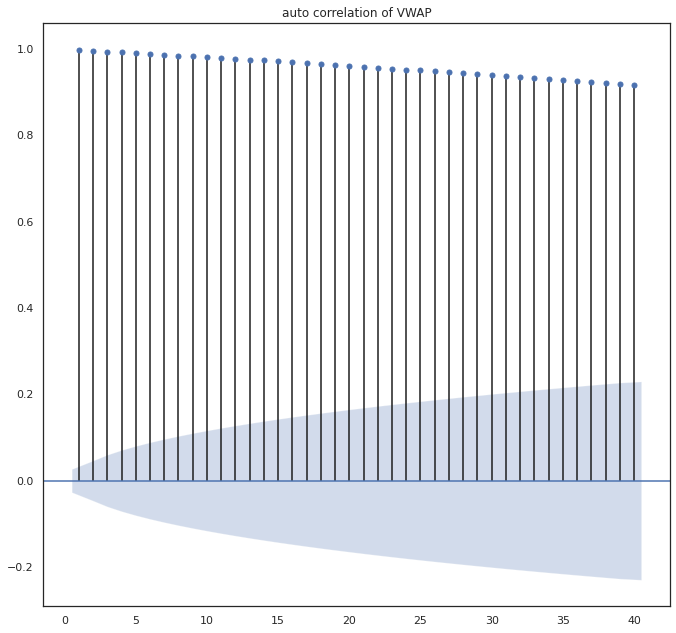

In [120]:
sm.graphics.tsa.plot_acf(df['VWAP'].iloc[1:], lags=40,title='auto correlation of VWAP',zero=False)
plt.show()

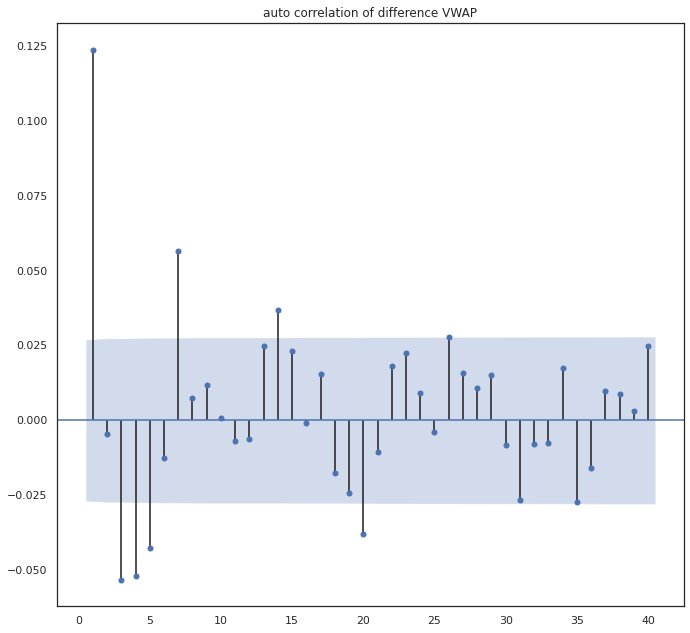

In [121]:
sm.graphics.tsa.plot_acf(df['vwap_diff'].iloc[7:], lags=40,title='auto correlation of difference VWAP',zero=False)
plt.show()

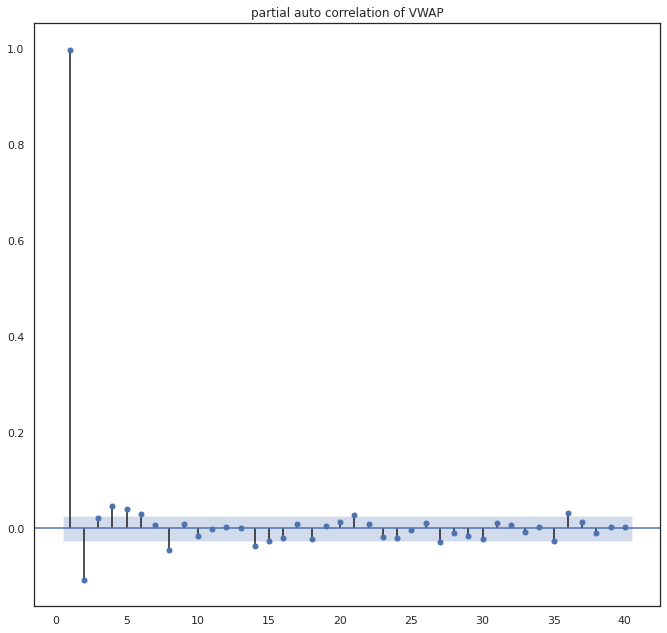

In [122]:
sm.graphics.tsa.plot_pacf(df['VWAP'].iloc[1:], lags=40,title='partial auto correlation of VWAP',zero=False)
plt.show()

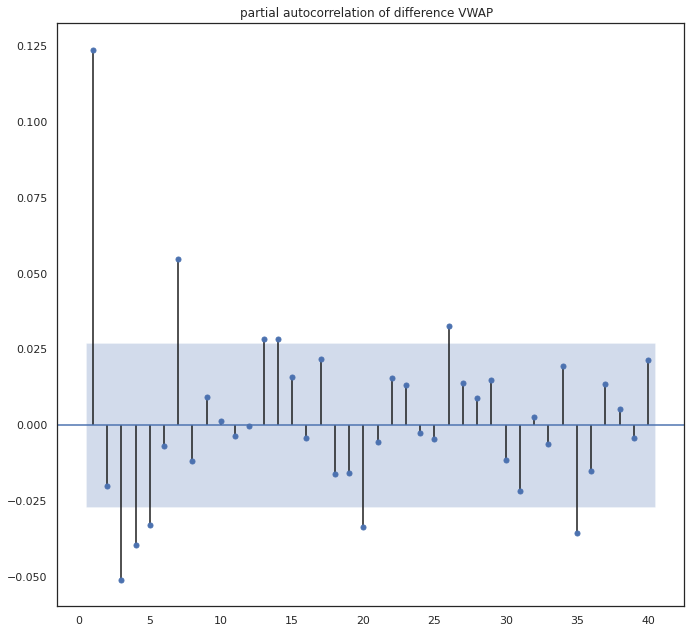

In [123]:
sm.graphics.tsa.plot_pacf(df['vwap_diff'].iloc[1:], lags=40,title='partial autocorrelation of difference VWAP  ',zero=False)
plt.show()

<b> Feature Engineering </b>

In [124]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,vwap_diff
Date,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,14.15
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,11.27
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,20.66
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,13.46


In [125]:
df=df.reset_index()

In [126]:
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)

In [127]:

df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek


In [128]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,...,1010.799805,1010.160950,1006.543823,14.784650,22.771172,47.599754,1,1,3,0
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,...,251.699997,251.699997,251.699997,14.784650,22.771172,47.599754,1,1,4,1
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,...,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,1,1,5,2
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,...,268.683319,268.683319,268.683319,15.642277,15.642277,15.642277,1,1,6,3
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,...,282.899994,275.100006,275.100006,11.255332,18.105661,18.105661,1,1,7,4


In [129]:

df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]


In [130]:
df_valid['Date'].describe()

count                     577
unique                    577
top       2019-01-01 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2021-04-30 00:00:00
Name: Date, dtype: object

In [131]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df_train.VWAP,lags=3, exog=df_train[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.353
Method:               Conditional MLE   S.D. of innovations             29.250
Date:                Mon, 07 Nov 2022   AIC                              6.768
Time:                        06:24:19   BIC                              6.822
Sample:                             3   HQIC                             6.787
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -0.0052      0.007     -0.754      0.451      -0.019       0.008
VWAP.L1                 0.4672      0.059      7.906      0.000       0.351       0.583
VWAP.L2         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [132]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.353
Method:               Conditional MLE   S.D. of innovations             29.250
Date:                Mon, 07 Nov 2022   AIC                              6.768
Time:                        06:24:20   BIC                              6.822
Sample:                             3   HQIC                             6.787
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -0.0052      0.006     -0.931      0.352      -0.016       0.006
VWAP.L1                 0.4672      0.134      3.479      0.001       0.204       0.730
VWAP.L2         

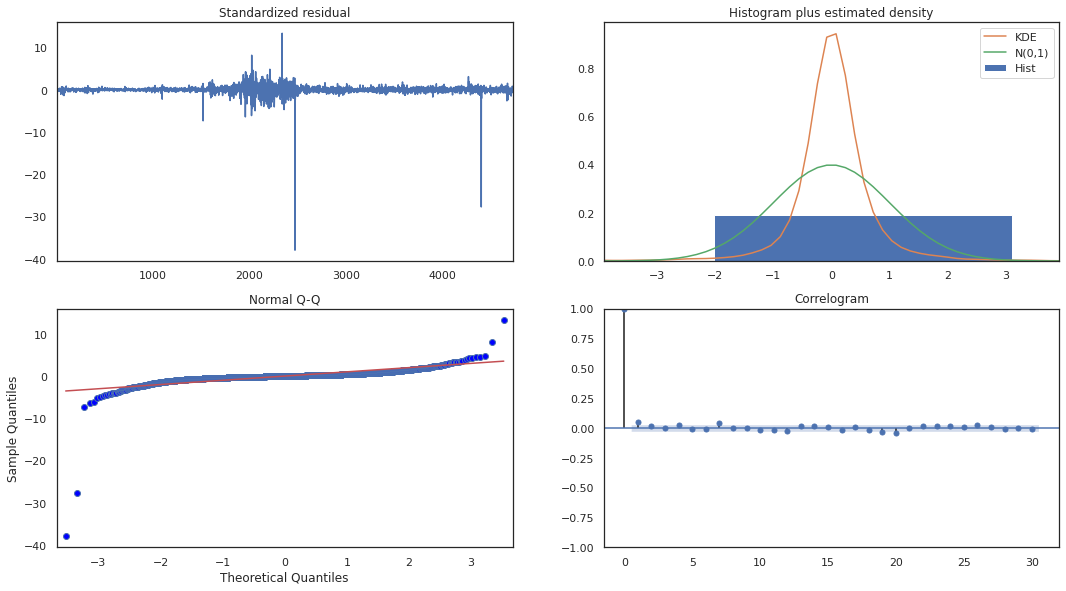

In [133]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

<b> AUTO-ARIMA Model </b>

In [134]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=45769.461, Time=4.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45860.449, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45799.168, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45797.991, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45858.618, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45792.034, Time=4.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45784.512, Time=5.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=45769.033, Time=9.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=45777.210, Time=4.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=45775.336, Time=12.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=14.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=45768.822, Time=5.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=45781.075, Time=3.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=45769.990, Time=11.20 sec
 ARIMA(1,1,4)(0,0,0)[0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4729
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -22877.483
Date:                Mon, 07 Nov 2022   AIC                          45766.967
Time:                        06:26:38   BIC                          45805.734
Sample:                             0   HQIC                         45780.593
                               - 4729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1585      0.056     20.777      0.000       1.049       1.268
ar.L2         -0.7675      0.051    -15.118      0.000      -0.867      -0.668
ma.L1         -1.0462      0.056    -18.550      0.000      -1.157      -0.936
ma.L2          0.6411      0.047     13.682      0.000       0.549       0.733
ma.L3          0.0375      0.013      2.876      0.004       0.012       0.063
sigma2       933.9666      1.503    621.538      0.000     931.021     936.912
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          53010351.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.91   Skew:                           -14.74
Prob(H) (two-sided):                  0.00   Kurtosis:                       520.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

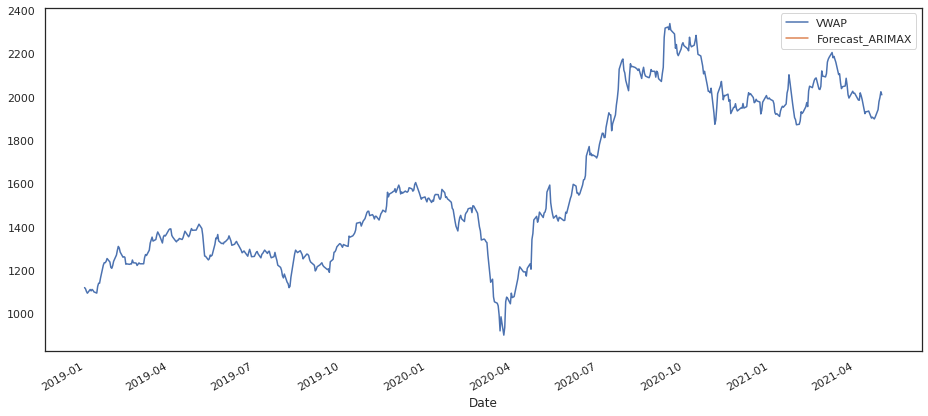

In [136]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

# FBProphet

In [148]:
# !pip install fbprophet

In [150]:
from fbprophet import Prophet

model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

In [ ]:
model_fbp.plot_components(forecast)

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

In [ ]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

ARIMA, Prophet and LightGBM models give a fair rmse and mae score. Let's see if deep learning models can do a better job in fitting to our dataset.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [ ]:
fig = plt.figure(figsize = (17,25))
ax = fig.gca()
hist=df.hist(ax = ax)

In [ ]:
dataset = df[exogenous_features].values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [ ]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [ ]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)

In [ ]:
model.summary()

In [ ]:
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

LSTM gives an excellent score on our dataset. Let's checkout a simple RNN model!

In [ ]:
model = Sequential()
model.add(SimpleRNN(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()

In [ ]:
yhat2 = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat2)
print('rmse:{} MAE:{}'.format(rmse,mae))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat2, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

<b> Analyzing residuals </b>

In [ ]:
residuals=df_valid.VWAP-df_valid.Forecast_ARIMAX

In [ ]:
dicky_fuller_test((residuals))

In [ ]:
residuals.plot()

### In the last part we cannot find the dataset of stocks after Ukraine war online.But i have run above model on different two-three more data set